In [3]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

sys.path.append(os.path.abspath('..'))

from src.model import ECGCNN


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ECGCNN().to(device)
model_path = "../models/best_cnn.pth"

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Model loaded successfully.")
else:
    raise FileNotFoundError("Model file not found. Please run training first.")


Model loaded successfully.


In [5]:
class ECGWindowDataset(Dataset):
    def __init__(self, windows_dir, record_ids):
        self.X = []
        self.y = []

        for rid in record_ids:
            self.X.append(np.load(windows_dir / f"{rid}_windows.npy"))
            self.y.append(np.load(windows_dir / f"{rid}_labels.npy"))

        self.X = np.concatenate(self.X, axis=0)
        self.y = np.concatenate(self.y, axis=0)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.long)
        )


In [6]:
WINDOWS_DIR = Path("..") / "data" / "windows"

dataset = ECGWindowDataset(
    windows_dir=WINDOWS_DIR,
    record_ids=['100', '101', '103', '105']
)

loader = DataLoader(dataset, batch_size=32, shuffle=False)


In [7]:
all_preds = []
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)           # (B, T, C)
        y = y.to(device)

        x = x.permute(0, 2, 1)     # ✅ (B, C, T)

        out = model(x)
        probs = torch.softmax(out, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy()[:, 1])  # P(Abnormal)


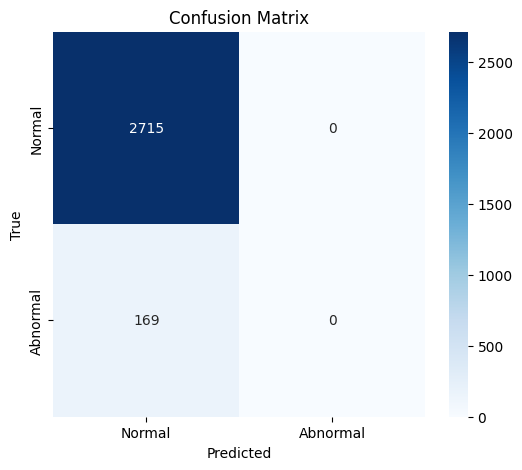

In [8]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal', 'Abnormal'],
    yticklabels=['Normal', 'Abnormal']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [9]:
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=['Normal', 'Abnormal']
    )
)


              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97      2715
    Abnormal       0.00      0.00      0.00       169

    accuracy                           0.94      2884
   macro avg       0.47      0.50      0.48      2884
weighted avg       0.89      0.94      0.91      2884



c:\Users\nayak\anaconda3\envs\ecgdata\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nayak\anaconda3\envs\ecgdata\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nayak\anaconda3\envs\ecgdata\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

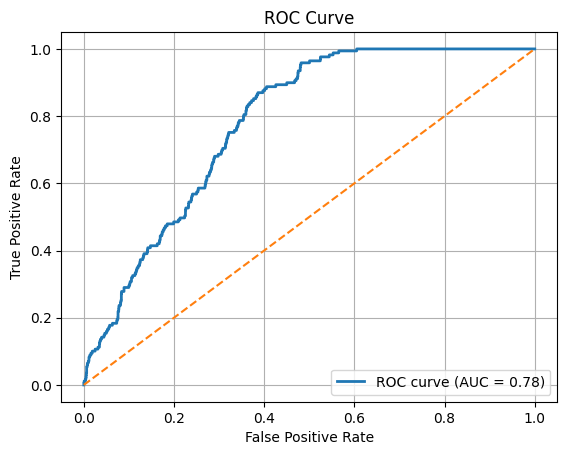

In [10]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
